# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 2 : Optimization for Machine Learning, AMMI Master's in Machine Intelligence
    Authors : Robert Gower, Alexandre Gramfort, Pierre Ablin, Mathurin Massias
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- (CG) nonlinear conjugate grad

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- **Each** student must send their jupyter notebook solutions **before the 16th of February at 23:55**  to **gowerrobert@gmail.com**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "LIONEL"
ln1 = "NGOUPEYOU TONDJI"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab2", ln1, fn1])) + ".ipynb"
print(filename)

lab2_ngoupeyou tondji_lionel.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [2]:
%matplotlib inline

In [3]:
from time import time

import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
from numba import njit

In [4]:
# choose a large font size by default and use tex for math
usetex = False # change this to True if you have a working LaTeX install

fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.rcParams.update(params)

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [5]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / n + lbda

In [6]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [7]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [8]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [9]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

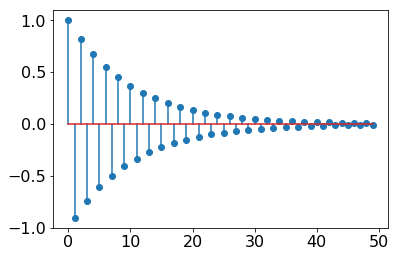

In [10]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [11]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

2.89889052581468e-06

In [12]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

2.924919845292426e-07

### Choice of the model

In [13]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [14]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.061226653663832835


### Get a very precise minimum to compute distances to minimum

In [15]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.5103443297159146
9.929974145064337e-09


<a id='batch'></a> 

## 3. Deterministic/Batch methods (GD, AGD, BFGS)

### Define a class to monitor iterations

In [16]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [17]:
# Number of iterations
n_iter = 50

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the GD solver in the cell below

In [18]:
@njit
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        
        x = x - step*grad(x, *args)
#         x_new = x - step*grad(x, *args)
#         x = x_new
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [19]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the AGD solver in the cell below

In [20]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        if i % store_every == 0:
            x_list.append(x.copy())
        ### TODO
        x_new = y - step*grad(y, *args)
        t_new = 0.5 * (1 + np.sqrt(1 + 4*(t**2)))
        y_new = x_new + (1/t_new)*(t - 1)*(x_new - x)
        x = x_new
        t = t_new
        y = y_new
        ### END TODO
    return x, x_list

In [21]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### scipy.optimize's conjuguate gradient

Let's compare with ``scipy.optimize``'s nonlinear conjuguate gradient solver. First, define a function to run scipy algorithms and return the list of iterates.

In [22]:
class callback():
    def __init__(self):
        self.x_list = []
    
    def __call__(self, x):
        self.x_list.append(x.copy())
        
        
def scipy_runner(scipy_algo):
    def run(*args, **kwargs):
        cb = callback()
        x = scipy_algo(*args, **kwargs, callback=cb)
        return x, cb.x_list
    return run

In [23]:
# Nonlinear Conjugate gradient algorithm
from scipy.optimize import fmin_cg

x_init = np.zeros(d)

monitor_cg = monitor(scipy_runner(fmin_cg), loss, x_min, (A, b ,lbda))
monitor_cg.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), gtol=1e-9)

         Current function value: 0.510364
         Iterations: 50
         Function evaluations: 81
         Gradient evaluations: 81


### scipy.optimize's L-BFGS

Let's compare with ``scipy.optimize``'s L-BFGS solver

In [24]:
# L-BFGS algorithm
from scipy.optimize import fmin_l_bfgs_b


x_init = np.zeros(d)

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [25]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("objective")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)
    

def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

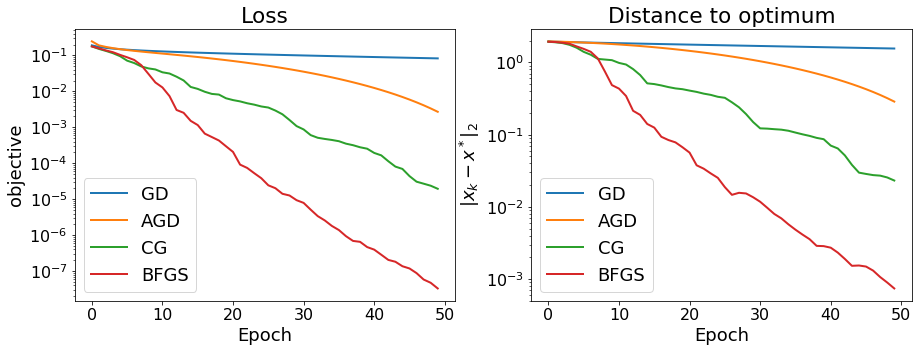

In [26]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs]

solvers = ["GD", "AGD", "CG", "BFGS"]

plot_epochs(monitors, solvers)

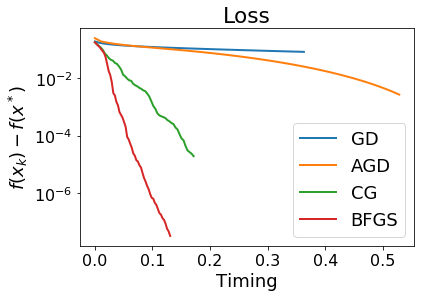

In [27]:
plot_time(monitors, solvers)

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about AGD? is it suprising ?

# ANSWER To QUESTIONS:

- As first conclusion, we can notice that all this batch solver (GD, AGD, CG, BFGS) studied above are using the full gradient to update in order to execute one update and this can be infeasible for large data sets. Another remark we can make is that the conjuguate gradient  and the BFGS are better than Gradient descend (GD) and the accelerated Gradient Descent (AGD). I think BFGS is faster because it's belong to quasi-Newton methods. 


- We saw in lectures that GD have a convergence order of O(1/ T) while AGD (or Fista) have a convergence order of O(1/ T^2) that indicate that AGD have a faster convergence than GD. In our graph we saw that GD converge faster than AGD and I think the fact that GD converge faster than AGD is suprising.

<a id='stoc'></a> 
## 4. Stochastic methods

In [28]:
n_iter = 50

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [29]:
@njit
def sgd(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        x = x - (1/np.sqrt(idx + 1)) * step * grad_i(i, x, *args)
        ### END TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [30]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, iis, grad_i, n_iter * n, step0, args=(A, b, lbda))

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [31]:
@njit
def sag(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        g_new = grad_i(i, x, *args)
        averaged_gradient += (1/n) * (grad_i(i, x, *args) - gradient_memory[i]) 
        gradient_memory[i] = g_new
        x = x - step * averaged_gradient
        ### END OF TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [32]:
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, iis, grad_i, n_iter * n, step, args=(A, b, lbda))

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [33]:
@njit
def svrg(x_init, iis, grad, grad_i, n_iter=100, step=1., store_every=1, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    x_list = []
    for idx in range(n_iter):
        
        ### TODO
        
        mu = grad(x_old, *args)
        
        for t in range(n):
            i = iis[t+idx*n]
            x = x - step*(grad_i(i, x, *args) - grad_i(i, x_old, *args) + mu)
        
        x_old = x

        ### END TODO        
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [34]:
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, iis, grad, grad_i, n_iter, step, args=(A, b, lbda))

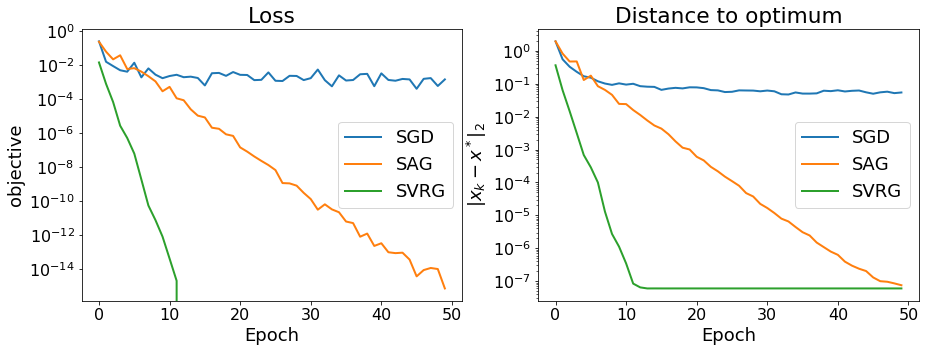

In [35]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

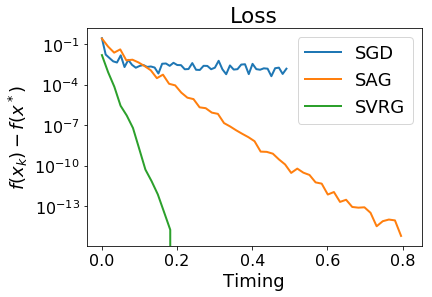

In [36]:
plot_time(monitors, solvers)

<a id='comp'></a> 
## 5. Numerical comparison

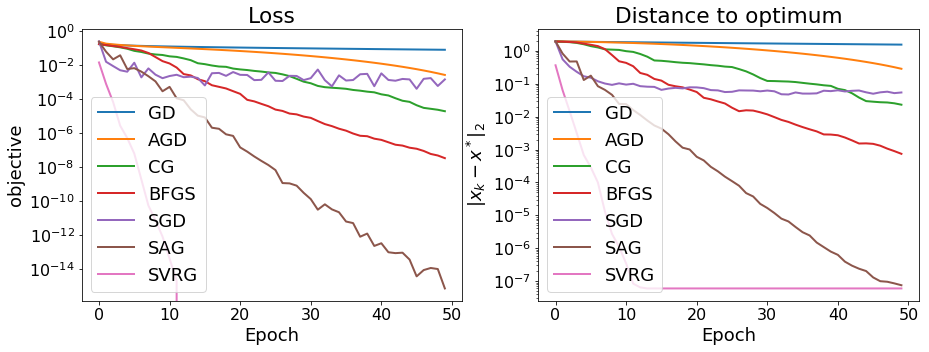

In [37]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

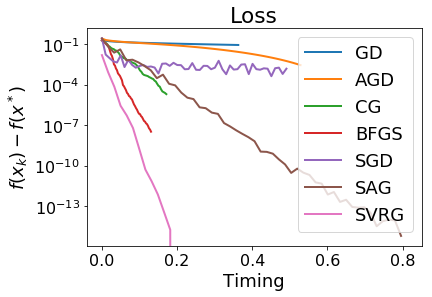

In [38]:
plot_time(monitors, solvers)

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- Compare and comment your results
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Conclude

 # Answers to questions

# 1. Comparison and comments

- We can notice that most of the stochastic methods converge faster than deterministic methods and in our case the Stochastic variance reduce gradient is faster than all the others methods in terms of convergence

 # 2. Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.

# For $\lambda = 1 / n$ and $\lambda = 1 / \sqrt n$

f_min1 :  0.5141893729324974
precision:  1.2779309423889761e-08
Value of lambda for 1 / n :   0.0001
         Current function value: 0.514212
         Iterations: 50
         Function evaluations: 83
         Gradient evaluations: 83


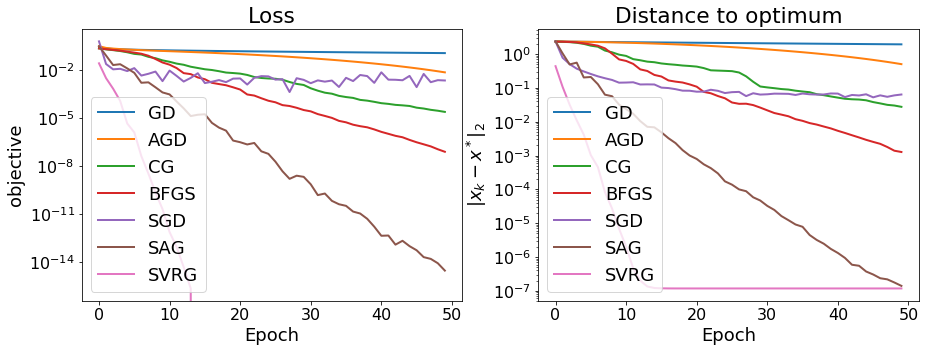

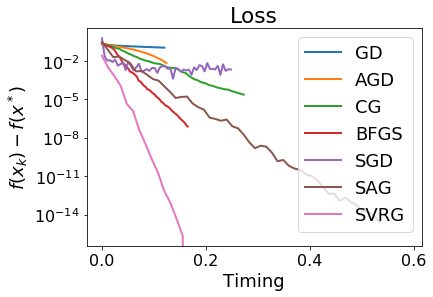

f_min1 :  0.5219873114585633
precision:  1.8114016285721823e-08
Value of lambda for 1 / sqrt(n) :   0.01
         Current function value: 0.521995
         Iterations: 50
         Function evaluations: 77
         Gradient evaluations: 77


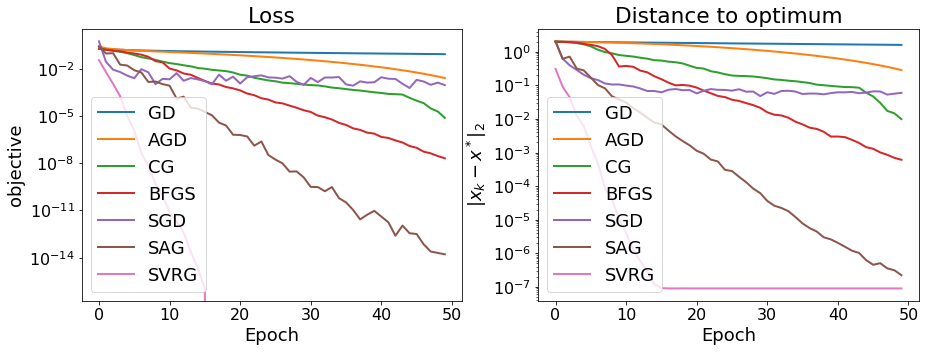

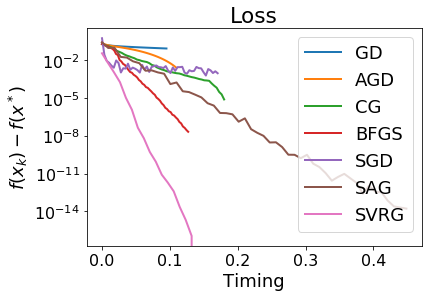

In [39]:
lbdas = [1. / n, 1. / n ** (0.5)]
for lbda in lbdas :
    A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
    x_init = np.zeros(d)
    x_min1, f_min1, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


    print('f_min1 : ',f_min1)
    print('precision: ',norm(grad_linreg(x_min1, A, b, lbda)))

    x_init = np.zeros(d)
    step = 1. / lipschitz_linreg(A, b, lbda)
    step_sgd = 1e-1
    max_squared_sum = np.max(np.sum(A ** 2, axis=1))
    step_sag = 1.0 / (max_squared_sum + lbda)



    monitor_gd1 = monitor(gd, loss, x_min1, (A, b ,lbda))
    monitor_agd1 = monitor(agd, loss, x_min1, (A, b ,lbda))
    monitor_cg1 = monitor(scipy_runner(fmin_cg), loss, x_min1, (A, b ,lbda))
    monitor_bfgs1 = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min1, (A, b ,lbda))
    monitor_sgd1 = monitor(sgd, loss, x_min1, (A, b ,lbda))
    monitor_sag1 = monitor(sag, loss, x_min1, (A, b ,lbda))
    monitor_svrg1 = monitor(svrg, loss, x_min1, (A, b ,lbda))


    # Running part
    if lbda == 1. / n:
        print('Value of lambda for 1 / n :  ', lbda)
    else :
        print('Value of lambda for 1 / sqrt(n) :  ', lbda)
    monitor_gd1.run(x_init, grad, n_iter, step, args=(A, b, lbda))
    monitor_agd1.run(x_init, grad, n_iter, step, args=(A, b, lbda))
    monitor_cg1.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), gtol=1e-9)
    monitor_bfgs1.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)
    monitor_sgd1.run(x_init, iis, grad_i, n_iter * n, step_sgd, args=(A, b, lbda))
    monitor_sag1.run(x_init, iis, grad_i, n_iter * n, step_sag, args=(A, b, lbda))
    monitor_svrg1.run(x_init, iis, grad, grad_i, n_iter, step_sag, args=(A, b, lbda))

    monitors = [monitor_gd1, monitor_agd1, monitor_cg1, monitor_bfgs1,
                monitor_sgd1, monitor_sag1, monitor_svrg1]

    solvers = ["GD", "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]

    plot_epochs(monitors, solvers)
    plt.show()
    plot_time(monitors, solvers)
    plt.show()

# Comments

- For $\lambda = 1 / n$, we have better convergence, but it is take more time and for $\lambda = 1 / \sqrt n$ we have convergence but with less time compare to the first case

# 3. Play also with the level of correlation between features (parameter corr above), and compare results with low and high correlation.

value of correlation between features =   -0.9
         Current function value: 0.523576
         Iterations: 50
         Function evaluations: 80
         Gradient evaluations: 80


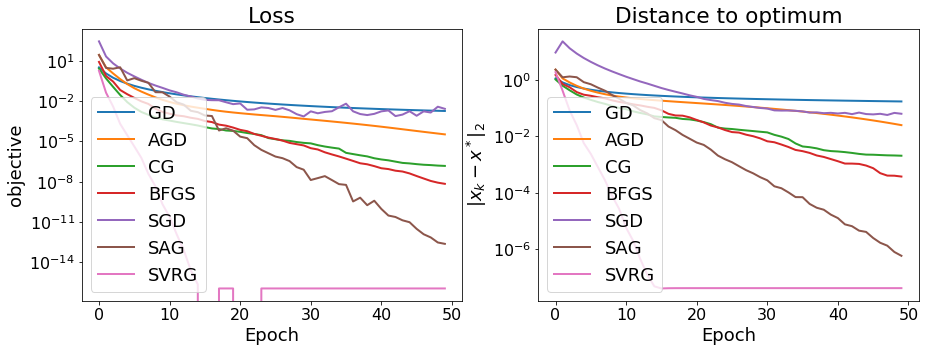

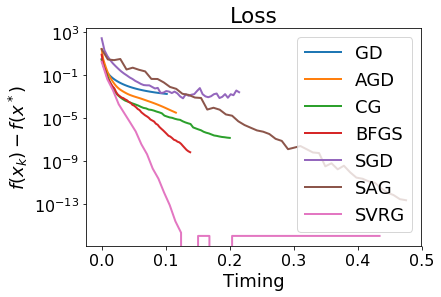

value of correlation between features =   -0.7
         Current function value: 0.542680
         Iterations: 49
         Function evaluations: 88
         Gradient evaluations: 87


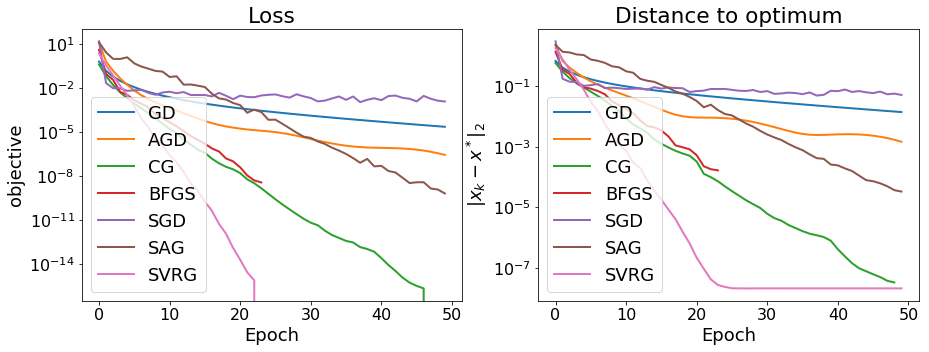

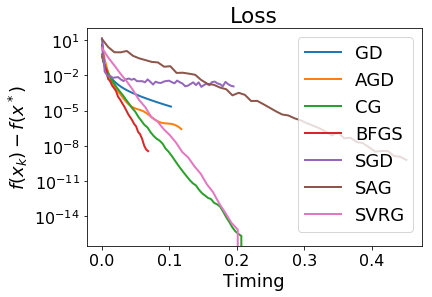

value of correlation between features =   -0.5
         Current function value: 0.526637
         Iterations: 29
         Function evaluations: 91
         Gradient evaluations: 80


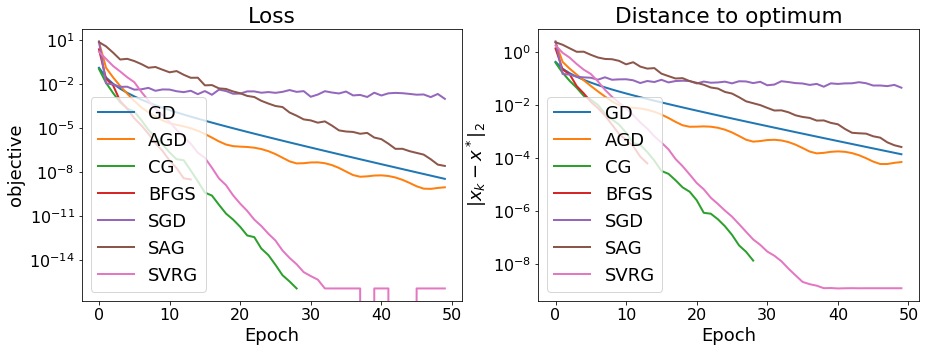

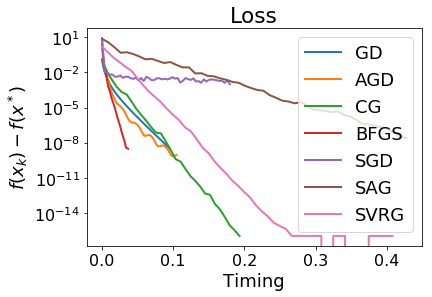

value of correlation between features =   -0.29999999999999993
Optimization terminated successfully.
         Current function value: 0.513942
         Iterations: 22
         Function evaluations: 33
         Gradient evaluations: 33


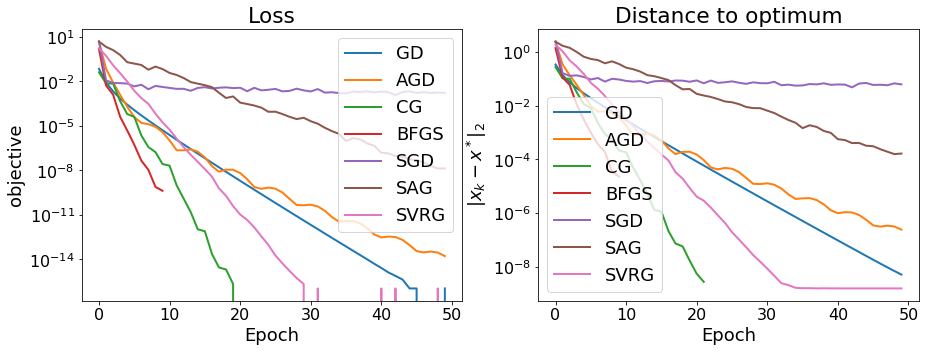

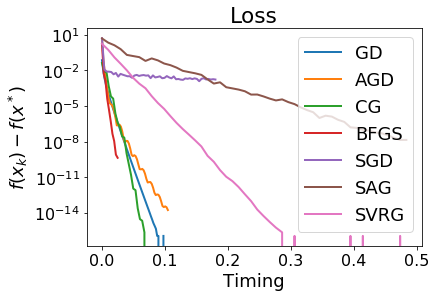

value of correlation between features =   -0.09999999999999998
Optimization terminated successfully.
         Current function value: 0.529951
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 20


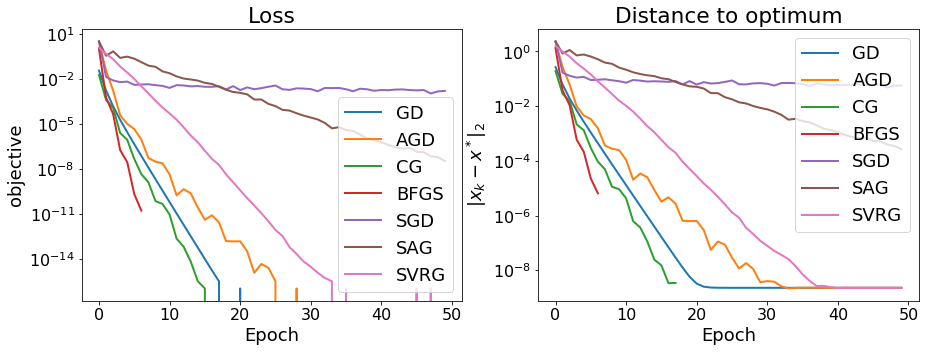

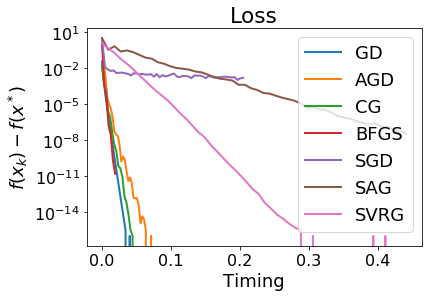

value of correlation between features =   0.09999999999999998
         Current function value: 0.525641
         Iterations: 14
         Function evaluations: 60
         Gradient evaluations: 49


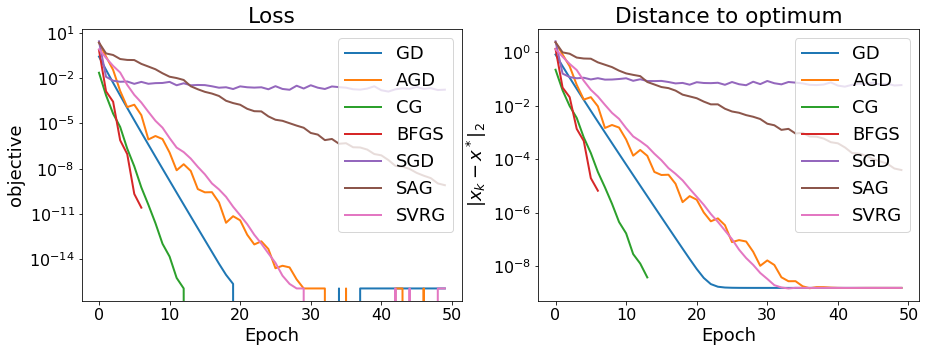

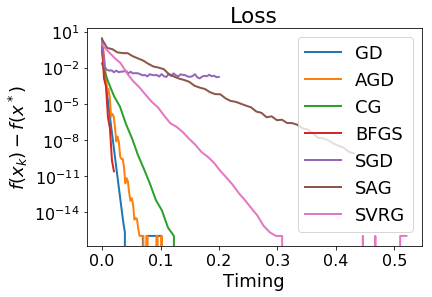

value of correlation between features =   0.30000000000000016
         Current function value: 0.527120
         Iterations: 23
         Function evaluations: 36
         Gradient evaluations: 35


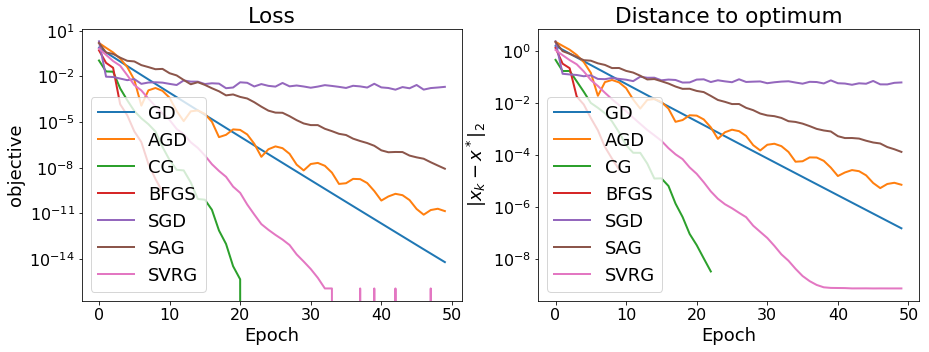

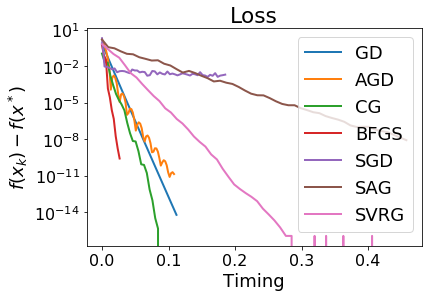

value of correlation between features =   0.5000000000000001
         Current function value: 0.531560
         Iterations: 34
         Function evaluations: 51
         Gradient evaluations: 50


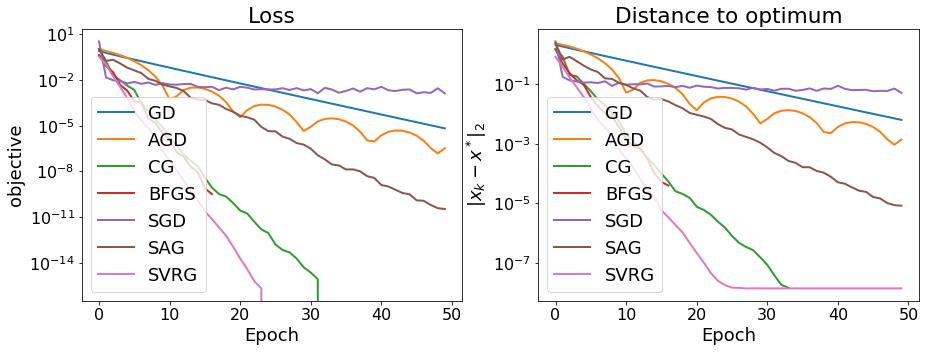

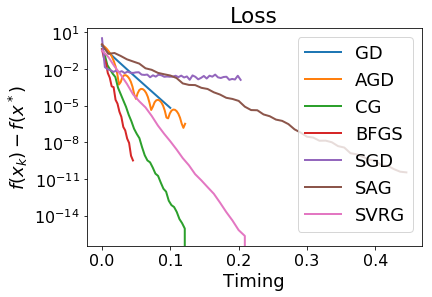

value of correlation between features =   0.7000000000000001
         Current function value: 0.524671
         Iterations: 50
         Function evaluations: 89
         Gradient evaluations: 89


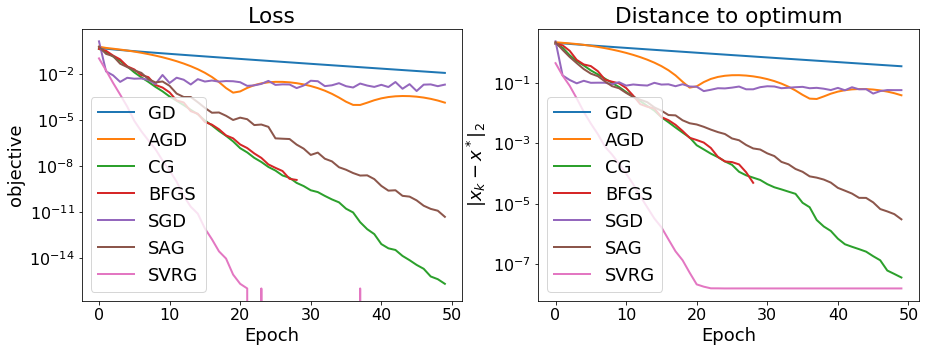

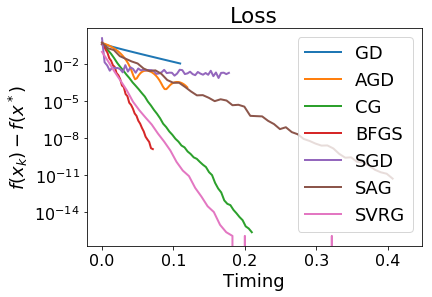

value of correlation between features =   0.9
         Current function value: 0.519047
         Iterations: 50
         Function evaluations: 79
         Gradient evaluations: 79


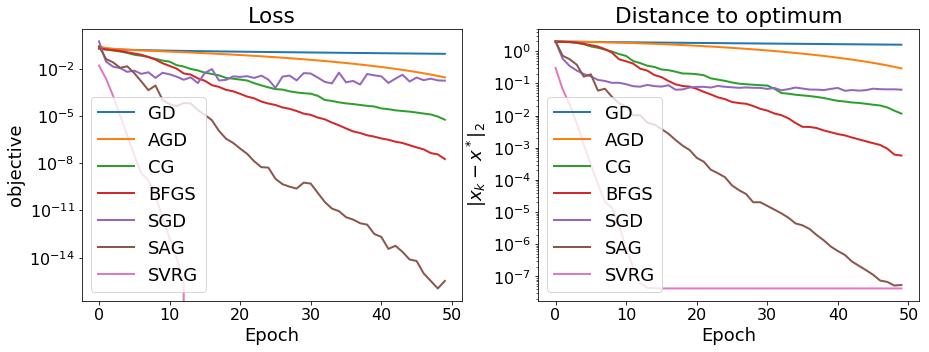

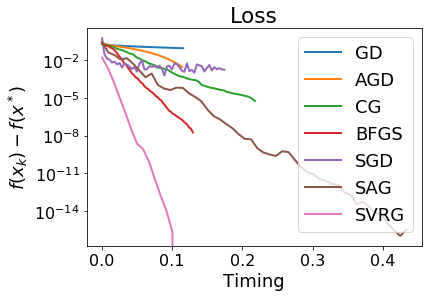

In [40]:
correlations = np.linspace(-0.9,0.9,10)
for corr in correlations : 
    A, b = simu_linreg(x_model_truth, n, std=1., corr = corr)

    lbda1 = 1. / np.sqrt(n)

    x_init = np.zeros(d)
    x_min1, f_min1, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda1), pgtol=1e-30, factr=1e-30)


    x_init = np.zeros(d)
    step = 1. / lipschitz_linreg(A, b, lbda1)
    step_sgd = 1e-1
    max_squared_sum = np.max(np.sum(A ** 2, axis=1))
    step_sag = 1.0 / (max_squared_sum + lbda1)



    monitor_gd1 = monitor(gd, loss, x_min1, (A, b ,lbda1))
    monitor_agd1 = monitor(agd, loss, x_min1, (A, b ,lbda1))
    monitor_cg1 = monitor(scipy_runner(fmin_cg), loss, x_min1, (A, b ,lbda1))
    monitor_bfgs1 = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min1, (A, b ,lbda1))
    monitor_sgd1 = monitor(sgd, loss, x_min1, (A, b ,lbda1))
    monitor_sag1 = monitor(sag, loss, x_min1, (A, b ,lbda1))
    monitor_svrg1 = monitor(svrg, loss, x_min1, (A, b ,lbda1))


    # Running part
    print('value of correlation between features =  ',corr)
    monitor_gd1.run(x_init, grad, n_iter, step, args=(A, b, lbda1))
    monitor_agd1.run(x_init, grad, n_iter, step, args=(A, b, lbda1))
    monitor_cg1.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda1), gtol=1e-9)
    monitor_bfgs1.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda1), pgtol=1e-30)
    monitor_sgd1.run(x_init, iis, grad_i, n_iter * n, step_sgd, args=(A, b, lbda1))
    monitor_sag1.run(x_init, iis, grad_i, n_iter * n, step_sag, args=(A, b, lbda1))
    monitor_svrg1.run(x_init, iis, grad, grad_i, n_iter, step_sag, args=(A, b, lbda1))
    
    monitors = [monitor_gd1, monitor_agd1, monitor_cg1, monitor_bfgs1,
            monitor_sgd1, monitor_sag1, monitor_svrg1]

    solvers = ["GD", "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]

    plot_epochs(monitors, solvers)
    plt.show()
    plot_time(monitors, solvers)
    plt.show()


# Comments

- We can notice that in general, the determistic methods (GD, AGD, CG, BFGS) are faster if the correlation between features is small whereas stochastic methods (SGD, SAG, SVRG) are faster when the correlation between features is big.


- Another thing we can notice is the fact that when the correlation between features is small sometime these methods do not converge whereas when the correlation between features is big deterministic and stochastic methods converge.

# 4. Conclusion

In general:

    - In the standard deterministic methods like gradient descent algorithm,  the parameters are updated on the entire data set iteratively. On a large data set, standard gradient descent algorithm not very efficient to find the global minimum of parameters (weights). 
    
    - Deterministic methods get the same optimum in the same number of iterations.  Stochastic methods like Stochastic gradient descent is well stochastic.  Because you are no longer using your entire training set a once, and instead picking one or more examples at a time in some likely random fashion, each time you tun SGD you will obtain a different optimum and a unique cost vs. iteration history.
    
    -  Stochastic methods (SGD) often converges much faster compared to Deterministic methods (GD) but the error function is not as well minimized as in the case of Deterministic methods (GD). Often in most cases, the close approximation that you get in Stochastic methods (SGD) for the parameter values are enough because they reach the optimal values and keep oscillating there.